# Num PCA components
Use explained variance and reconstruction error to determine the number of PCA components to use.

In [1]:
from elasticSearch.selected_docs import select_rep_path
import os
from elasticSearch.recursive_search import scanRecurse

## Data
- local: 195 (first) files
- server: 1000 random files across subdirectories

In [2]:
def get_directories():
    baseDir = '/mnt/stud/home/kgutekunst/visualizations/images/'
    resDir = '/mnt/stud/home/kgutekunst/visualizations/'
    if os.path.exists('/Users/klara/Documents/uni/bachelorarbeit/data/0/'):
        baseDir = '/Users/klara/Documents/uni/bachelorarbeit/images/'
        resDir = '/Users/klara/Developer/Uni/topic-analysis-text-data/results/'
    return baseDir,resDir

In [3]:
baseDir, resDir = get_directories()

In [4]:
paths = select_rep_path(baseDir, 10) if baseDir.startswith('/mnt/') else list(scanRecurse(baseDir))

In [5]:
import numpy as np


def rgb2gray(img):  # not normalized to [0,1]
    return 0.299*img[:,:,0] + 0.587*img[:,:,1] + 0.114*img[:,:,2]

def get_maximum_height_width(documents):
    max_w = 0
    max_h = 0
    for doc in documents:
        max_w = np.maximum(max_w, doc.shape[0])
        max_h = np.maximum(max_h, doc.shape[1])
    return max_w, max_h

def proprocess_docs(raw_documents, max_w, max_h):
    '''
    return same sized, greyscale documents as an array
    '''
    documents = []
    for doc in raw_documents:
        # same size for all documents
        C = np.ones((max_w,max_h))
        # convert to grayscale
        C[:doc.shape[0],:doc.shape[1]] = rgb2gray(doc)
        # 2d to 1d array
        documents.append(C.ravel())
    # list to array
    return np.asarray(documents)

In [6]:
from matplotlib import pyplot as plt


def plot_expl_var(pca, save=False, resDir:str='results/'):
    fig, ax = plt.subplots(figsize=(10,6))
    y = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(y, label="cumulative explained variance")
    plt.title("Cumulative explained variance")
    plt.xlabel("Number of components")
    plt.ylabel("Explained variance")
    plt.axhline(y = 0.9, color = 'r', linestyle = '-', label="90% explained variance")
    interp = np.interp(0.9, y, list(range(len(y))))
    plt.axvline(x=interp,color='grey', label="{} components".format(int(interp)))
    plt.legend()
    if save:
        plt.savefig(resDir + "cumulative_explained_variance.pdf", format="pdf")
    plt.show()

In [66]:
from sklearn.decomposition import PCA


def plot_rec_err(X_train, X_test, n_max=10, save=False, resDir:str='results/'):
    reconstr_err = []
    for i in range(1, n_max):
        pca = PCA(n_components=i)#, whiten=True)#, svd_solver="randomized")   
        pca.fit(X_train)
        X_test_pca = pca.transform(X_test)
        X_test_pca_inverse = pca.inverse_transform(X_test_pca)
        sqr_dif = (X_test - X_test_pca_inverse)**2
        print('squared dif ', np.mean(sqr_dif), sqr_dif.shape, np.sum(abs(X_test - X_test_pca_inverse)))
        reconstr_err.append(np.sqrt(np.mean(sqr_dif))/len(X_test[0])) # RMSE per pixel in [0,1]

    # plot reconstruction error
    plt.figure(figsize=(10,6))
    plt.plot(reconstr_err, label="reconstruction error")
    plt.title("Reconstruction error")
    plt.xlabel("Number of components")
    plt.ylabel("Reconstruction error")
    plt.legend()
    if save:
        plt.savefig(resDir + "reconstruction error.pdf", format="pdf")
    plt.show()
    

In [8]:
documents_raw = [plt.imread(fp) for fp in paths if fp.endswith(".png")]

In [9]:
max_w, max_h = get_maximum_height_width(documents_raw)
print(max_w, max_h)

880 1026


In [10]:
eigendocs = proprocess_docs(documents_raw, max_w=max_w, max_h=max_h)

In [11]:
from sklearn.model_selection import train_test_split


X_train, X_test = train_test_split(eigendocs, random_state=0)

In [12]:
pca = PCA(n_components=min(len(X_train), len(X_train[0])), whiten=True, svd_solver="randomized")   
pca.fit(X_train)

PCA(n_components=145, svd_solver='randomized', whiten=True)

In [13]:
#plot_expl_var(pca, save=False, resDir=resDir)

squared dif  0.016068189592131587 (49, 902880) 2046488.6817784437
squared dif  0.01594529216992474 (49, 902880) 2037096.1296574844
squared dif  0.01585910435129024 (49, 902880) 2034269.9648409646
squared dif  0.015801799402515426 (49, 902880) 2029924.7608240359
squared dif  0.015720005376243778 (49, 902880) 2019821.3484748728
squared dif  0.015635222762132604 (49, 902880) 2026303.9866409458
squared dif  0.015557522792580452 (49, 902880) 2031039.4593910926
squared dif  0.015513067837731091 (49, 902880) 2032225.5143632407
squared dif  0.015470538074868454 (49, 902880) 2029560.2229759223


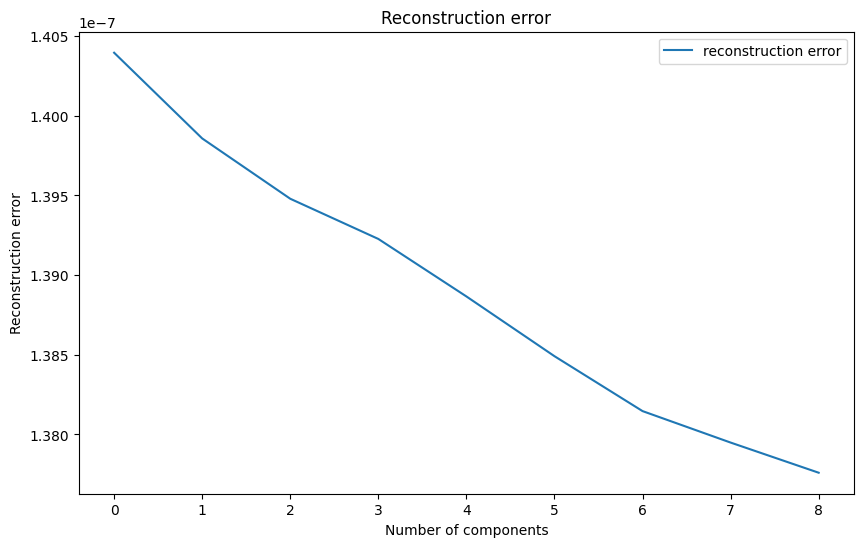

In [67]:
plot_rec_err(X_train, X_test, n_max= min(10,len(X_train),len(X_train[0])), save=False, resDir=resDir)